In [ ]:
%%capture
!pip install etna[classification]

In [ ]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

from etna.experimental.classification.feature_extraction import TSFreshFeatureExtractor
from tsfresh.feature_extraction.settings import MinimalFCParameters

from etna.experimental.classification import TimeSeriesBinaryClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

### Загрузка данных

Набор данных состоит из измерений шума двигателя, и задача заключается в диагностике наличия определенного паттерна поломки в двигателе

In [ ]:
!curl "https://timeseriesclassification.com/aeon-toolkit/FordA.zip" -o ford_a.zip
!unzip -q ford_a.zip -d ford_a

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34.6M  100 34.6M    0     0  5521k      0  0:00:06  0:00:06 --:--:-- 7641k


In [ ]:
def load_ford_a(path: pathlib.Path, dataset_name: str):
    train_path = path / (dataset_name + "_TRAIN.txt")
    test_path = path / (dataset_name + "_TEST.txt")
    data_train = np.genfromtxt(train_path)
    data_test = np.genfromtxt(test_path)

    X_train, y_train = data_train[:, 1:], data_train[:, 0]
    X_test, y_test = data_test[:, 1:], data_test[:, 0]

    y_train = y_train.astype("int64")
    y_test = y_test.astype("int64")

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = load_ford_a(pathlib.Path("ford_a"), "FordA")
y_train[y_train == -1], y_test[y_test == -1] = 0, 0  # transform labels to 0, 1

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3601, 500), (1320, 500), (3601,), (1320,))

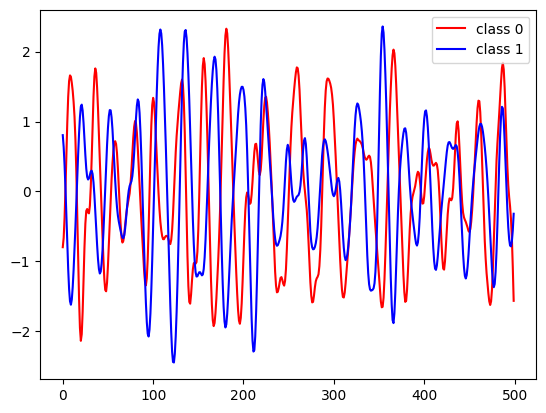

In [ ]:
for c in [0, 1]:
    class_samples = X_train[y_train == c]
    plt.plot(class_samples[0], label="class " + str(c), c=["r", "b"][c])
plt.legend(loc="best");

#### FE + модель

Для feature engineering используем библиотеку [tsfresh](https://tsfresh.readthedocs.io/en/latest/text/introduction.html)


[Что генерит tsfresh?](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)

In [ ]:
tsfresh_feature_extractor = TSFreshFeatureExtractor(
    default_fc_parameters=MinimalFCParameters(),
    fill_na_value=-100,
)

In [ ]:
model = LogisticRegression(max_iter=1000)
clf = TimeSeriesBinaryClassifier(feature_extractor=tsfresh_feature_extractor, classifier=model)

In [ ]:
mask = np.zeros(len(X_train))
for fold_idx, (train_index, test_index) in enumerate(KFold(n_splits=5).split(X_train)):
    mask[test_index] = fold_idx

In [ ]:
metrics = clf.masked_crossval_score(x=X_train, y=y_train, mask=mask)

Feature Extraction: 100%|██████████| 720/720 [00:00<00:00, 2986.21it/s]


In [ ]:
metrics

{'precision': [0.5336091958066558,
  0.5034126330120741,
  0.5270938738680675,
  0.48479549208199746,
  0.5303571428571429],
 'recall': [0.5294147077387275,
  0.5029400189827997,
  0.5260376744942281,
  0.4855088120003704,
  0.5289386330751553],
 'fscore': [0.515871165705291,
  0.48431786034207236,
  0.5236515337423313,
  0.4796875,
  0.5257560474951779],
 'AUC': [0.5514940193044844,
  0.5507712726964064,
  0.5509410881161978,
  0.5186734158461681,
  0.540038223755987]}

In [ ]:
{metric: np.mean(values) for metric, values in metrics.items()}

{'precision': 0.5158536675251876,
 'recall': 0.5145679692582561,
 'fscore': 0.5058568214569745,
 'AUC': 0.5423836039438488}